# Numenta Anomaly Benchmark

### Description

The datasets used in this notebook were gathered from the Kaggle datset: <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab> Numenta Anomaly Benchmark (NAB)</a>. Each subfolder contains a timeseries-like dataset of real world/artificial anomaly observations.

The full description of each dataset can be found <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab>here</a>.


### Purpose
The purpose of this notebook is to showcase various data processing and estimating techniques based on the NAB dataset. Timeseries forecasting and anomaly detection are closely related fields, both having enormous impact in the fields of finance and engineering.

---

## Table of contents
1. [Dataset](#1.0)
2. [Data Preparation](#2.0)
3. [Methods](#3.0)
   
      3.1 [Kmeans](#3.1)

      3.2 [LSTM Autoencoder](#3.2)

      3.3 [Markov](#3.3)

      3.4 [DBSCAN](#3.4)
      
      3.5 [Isolation Forest](#3.5)

4. [Comparison](#4.0)

#### But what is an anomaly?

According to this <a href=https://towardsdatascience.com/effective-approaches-for-time-series-anomaly-detection-9485b40077f1>Towards Data Science article: </a>:

> " ...a data point which is not following the common collective trend or seasonal or cyclic pattern of the entire data and is significantly distinct from rest of the data."

The 3 main approaches we can use to detect time-series anomalies are based on:

    1. Statistical estimation
    2. Unsupervised clustering
    3. ML algorithms

<a id="1.0"></a>

## 1. Dataset

#### 1.1 Visualization 
Since there are many data files with different patterns lets visualize a few of them.

For this notebook I chose a real dataset from TWITTER.

In [126]:
import os
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from matplotlib.pyplot import style
from sklearn.cluster import KMeans
from pyemma import msm
import tensorflow as tf
import seaborn as sns
from scipy import stats

style.use("seaborn-v0_8-dark")

In [127]:
NO_OF_PLOTS_SHOWN = 0

In [128]:
def plot_csv(path,nrows,ncols):
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,10))
    for i,f in enumerate(os.listdir(path)):
        df= pd.read_csv(path+f)
        if i < ncols:
            ax = axes[0,i]
        else:
            ax = axes[1,i-ncols]
        ax.plot(df["timestamp"], df["value"])
        ax.set_title(f[:-4])
        
        # axes.plot(x ="timestamp", y="value")
        

# path_art_anom = "data//realTweets//realTweets//"
# plot_csv(path_art_anom,2,5)
# df = pd.read_csv("data//artificialWithAnomaly//artificialWithAnomaly//art_daily_jumpsup.csv")

In [129]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    print()
    df["hr_avg"] = df['value'].rolling(window=60).mean()
    ax[0].plot(df["value"])
    ax[0].set_title("{} samples for {}\n from {}\n to {}".format(len(df),f.split("_")[2][:-4],min(df.timestamp),max(df.timestamp)))
    ax[0].set_xlabel("Time (5min)")
    ax[0].set_ylabel("Mentions")
    
    ax[1].plot(df["hr_avg"])
    #ax[1].title(f.split("_")[2][:-4])
    ax[1].set_xlabel("Time (1hr)")
    ax[1].set_ylabel("Mentions")
    
    

#### 1.2 Distribution of data (+Feature extraction)

In [130]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["day_of_week"] = df["timestamp"].dt.weekday
    df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
    df["hour_of_day"] = df["timestamp"].dt.hour

    sns.barplot(y = df.groupby(df["hour_of_day"]).sum(numeric_only=True)["value"],x=df.groupby(df["hour_of_day"]).sum(numeric_only=True).index,ax=ax[0])
    sns.barplot(y = df.groupby(df["day_of_week"]).sum(numeric_only=True)["value"],x=df.groupby(df["day_of_week"]).sum(numeric_only=True).index,ax=ax[1])
    ax[1].set_xticklabels(["Monday","Tuseday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    ax[0].set_title(f.split("_")[2][:-4])
    ax[1].set_title(f.split("_")[2][:-4])
    #sns.displot(df["hr_avg"],ax=ax[1])
    

#### 1.3 Outliers

In [131]:
df["z-score"] = stats.zscore(df["value"])

Text(0.5, 0, 'log z-score')

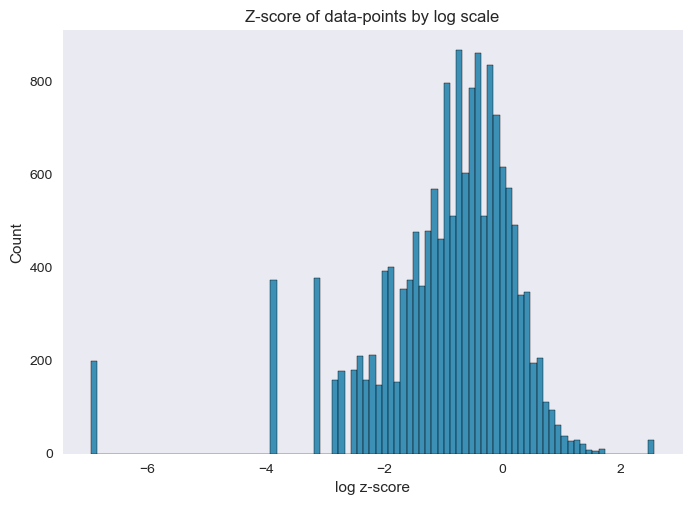

In [132]:
sns.histplot(np.log(np.abs(df["z-score"])))
plt.title("Z-score of data-points by log scale")
plt.xlabel("log z-score")

In [133]:
print("{} data-points with higher z-score than 2".format(len(df[np.abs(df["z-score"]) > 2])))
print("{} data-points with higher z-score than 3".format(len(df[np.abs(df["z-score"]) > 3])))
print("{} data-points with higher z-score than 10".format(len(df[np.abs(df["z-score"]) > 10])))


426 data-points with higher z-score than 2
135 data-points with higher z-score than 3
29 data-points with higher z-score than 10


#### 1.4 Autocorrelation of signals

In [134]:
i = 0
for i in range(0,len(os.listdir(path)[:NO_OF_PLOTS_SHOWN])-1,2):
    if i%2 ==0:
        try:
            df1 = pd.read_csv(path+os.listdir(path)[i])
            df2 = pd.read_csv(path+os.listdir(path)[i+1])
            
            fig,ax = plt.subplots(1,2,figsize=(15,5))
            df = pd.read_csv(path+f)
            tsaplots.plot_acf(df1["value"], lags=500,ax=ax[0])
            tsaplots.plot_acf(df2["value"], lags=500,ax=ax[1])
            ax[0].set_title(os.listdir(path)[i].split("_")[2][:-4])
            ax[1].set_title(os.listdir(path)[i+1].split("_")[2][:-4])
            # plt.show()
        except:
            pass
    

## 2. Data Preparation

#### 2.1 Feature Engineering

In [135]:
df = pd.read_csv(path+"Twitter_volume_AAPL.csv")

#### Let's use log values for data

<AxesSubplot: ylabel='value'>

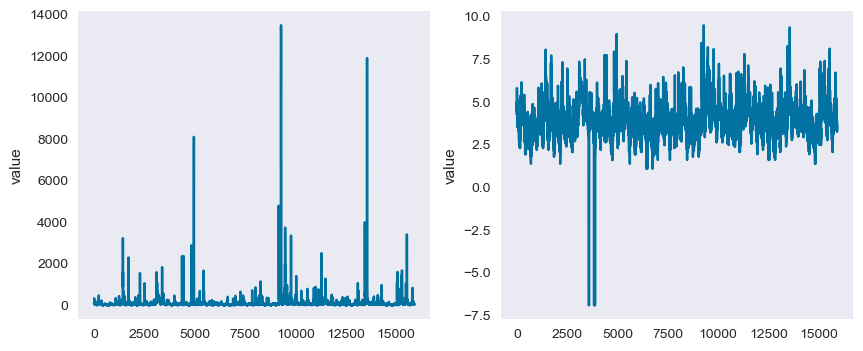

In [136]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot(df["value"],ax=axes[0])
sns.lineplot(np.log(np.abs(df["value"]+0.001)),ax=axes[1])

In [137]:
df["value"] = np.log(np.abs(df["value"])+0.0001)

In [138]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day_of_week"] = df["timestamp"].dt.weekday
df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
df["hour_of_day"] = df["timestamp"].dt.hour

#### 2.2 Standard Scaling + PCA

In [139]:
st_scaler = StandardScaler()
mm_scaler = StandardScaler()
pca = PCA(n_components=2)
norm_val = mm_scaler.fit_transform(df[["value","day_of_week","week_of_year","hour_of_day"]])
pca_mat = pca.fit_transform(norm_val)
pca_mat = st_scaler.fit_transform(pca_mat)
pca_df = pd.DataFrame(pca_mat,columns=["feature1","feature2"])

## 3. Methods

#### 3.1 Kmeans clustering

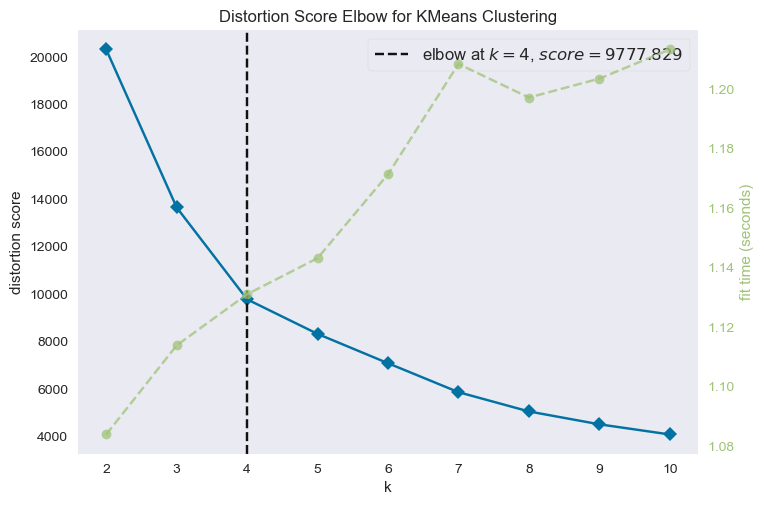

In [140]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(pca_df)
Elbow_M.show();

In [141]:
clf_kmeans = KMeans(n_clusters=4)

pca_df["cluster"] = clf_kmeans.fit_predict(pca_df)

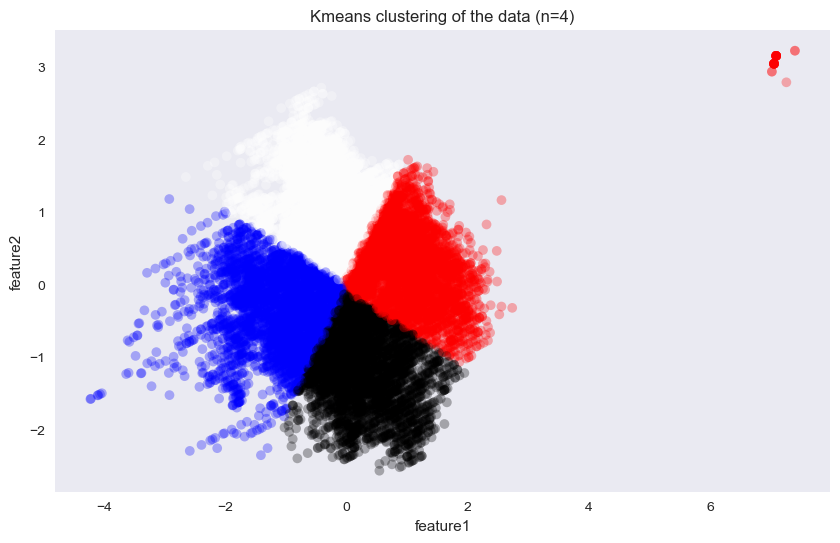

In [142]:
fig= plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_df["feature1"],y=pca_df["feature2"],c=pca_df["cluster"],cmap="flag", alpha=0.3,linewidth=0)
plt.title("Kmeans clustering of the data (n=4)")
plt.show()

In [143]:
def getDistanceByPoint(data, model):
    distance = pd.Series(index=range(len(data)))
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance 

In [144]:
distance = getDistanceByPoint(pca_df[["feature1","feature2"]], clf_kmeans)
number_of_outliers = int(0.01*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
pca_df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\4182611596.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series(index=range(len(data)))


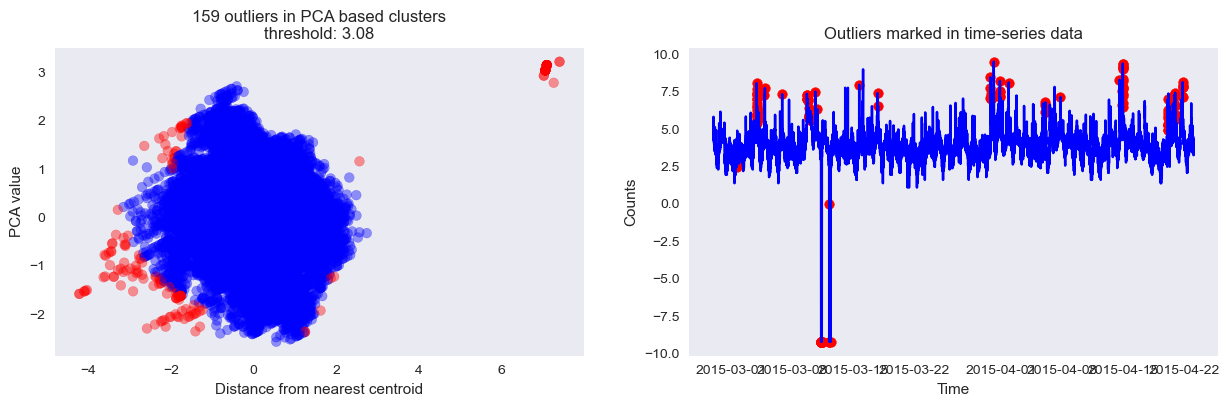

In [145]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

colors = {0:'blue', 1:'red'}
axes[0].scatter(pca_df['feature1'], pca_df['feature2'], c=pca_df["anomaly21"].apply(lambda x: colors[x]),alpha=0.4)
axes[0].set_title("{} outliers in PCA based clusters\nthreshold: {:.2f}".format(len(pca_df.loc[pca_df["anomaly21"]==1]), threshold))
axes[0].set_xlabel("Distance from nearest centroid")
axes[0].set_ylabel("PCA value")


a = df.loc[pca_df['anomaly21'] == 1, ['timestamp', 'value']]
axes[1].plot(df['timestamp'], df['value'], color='blue')
axes[1].scatter(a['timestamp'],a['value'], color='red')
axes[1].set_title("Outliers marked in time-series data")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Counts")

plt.show()

In [146]:
RATIO = 0.8
norm_df = pd.DataFrame(norm_val,columns=["value","day_of_week","week_of_year","hour_of_day"] )
X_train = norm_df[:int(RATIO*len(norm_val))]["value"]
X_test = norm_df[int(RATIO*len(norm_val)):]["value"]

#### 3.2 LSTM Autoencoder 

In [147]:
def autoencoder(X_train):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[0],))
    x = tf.keras.layers.LSTM(16,activation="relu",return_sequences=True)(inputs)
    x = tf.keras.layers.LSTM(4,activation="relu",return_sequences=False)(x)
    x=tf.keras.layers.RepeatVector(X_train.shape[0])(x)
    x = tf.keras.layers.LSTM(4,activation="relu",return_sequences=True)(x)
    x = tf.keras.layers.LSTM(16,activation="relu",return_sequences=True)(x)
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x)
    
    model = tf.keras.models.Model(inputs,output)
    
    return model

#### 3.3 Markov Process

In [148]:
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1,sparse=True)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(sequence)
    return df_anomaly

In [149]:
x1 = (df['value'] <=30).astype(int)
x2= ((df['value'] > 30) & (df['value']<=50)).astype(int)
x3 = ((df['value'] > 50) & (df['value']<=80)).astype(int)
x4 = ((df['value'] > 80) & (df['value']<=120)).astype(int)
x5 = (df['value'] >120).astype(int)

df_mm = x1 + 2*x2 + 3*x3 + 4*x4 +5*x5

In [150]:
# df_anomaly = markovAnomaly(df["value"], 5, 0.20) # ONLY RUN IF YOU GOT A FEW MINS TO SPARE
# df_anomaly = pd.Series(df_anomaly)
# print(df_anomaly.value_counts())

#### 3.4 DBSCAN

#### 3.5 Isolation Forest

In [151]:
data = df[['value', "day_of_week","week_of_year","hour_of_day"]]

data = pd.DataFrame(norm_val)
# train isolation forest 
model =  IsolationForest(contamination = 0.01)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    15742
1      160
Name: anomaly25, dtype: int64


Text(0, 0.5, 'Counts')

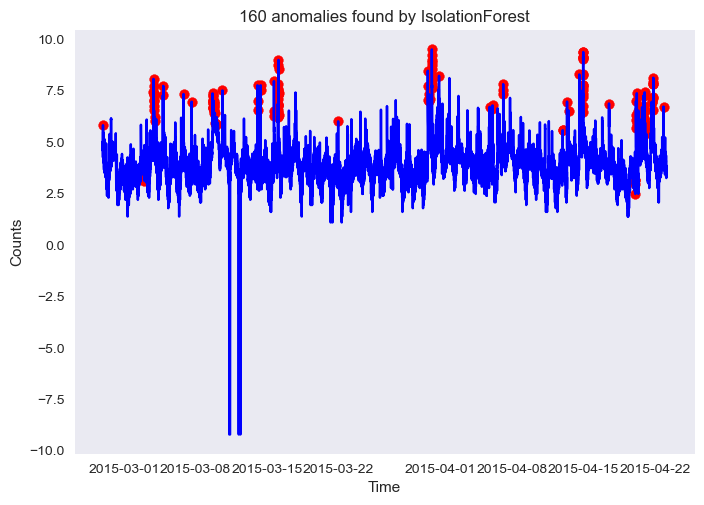

In [152]:
a = df.loc[df['anomaly25'] == 1, ['timestamp', 'value']]
plt.plot(df['timestamp'], df['value'], color='blue')
plt.scatter(a['timestamp'],a['value'], color='red')

plt.title("{} anomalies found by IsolationForest".format(len(df[df["anomaly25"] ==1])))
plt.xlabel("Time")
plt.ylabel("Counts")